# Exogenous Causal Forest

In [1]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(1000, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(1000, n_samples))

In [13]:
from econml.grf import CausalForest
est = CausalForest(criterion='het', n_estimators=4000, min_samples_leaf=20,
                   min_impurity_decrease = 0, max_samples=0.9, warm_start=False, inference=True,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [14]:
%time est.fit(X, T, y.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Wall time: 19.8 s


CausalForest(criterion='het', min_impurity_decrease=0, min_samples_leaf=20,
             n_estimators=4000, n_jobs=-1, random_state=1235)

In [4]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Wall time: 1.91 s


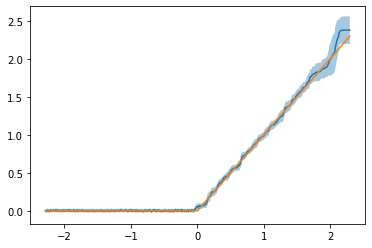

In [5]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

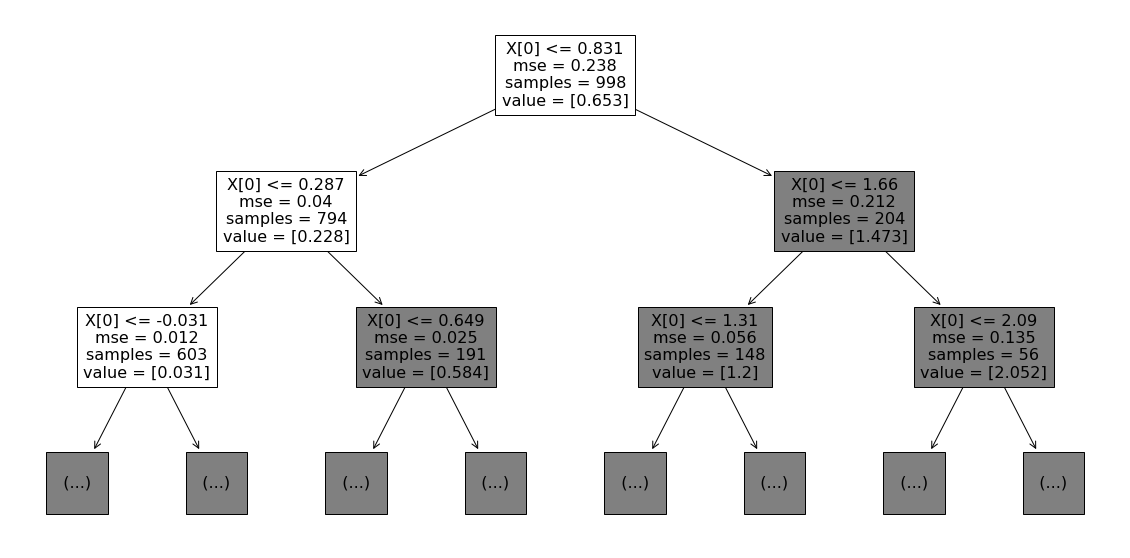

In [6]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

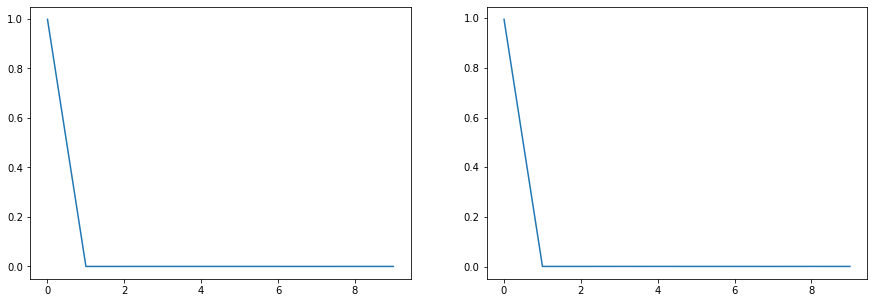

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [57]:
est.decision_path(X_test[:1])

(<1x297356 sparse matrix of type '<class 'numpy.int64'>'
 	with 34091 stored elements in Compressed Sparse Row format>,
 array([     0,     77,    154, ..., 297208, 297283, 297356], dtype=int32))

In [58]:
est.apply(X_test[:1])

array([[11, 19, 27, ..., 16, 24, 12]], dtype=int64)

### Running time comparison with a simple regression forest predicting the treatments

In [7]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=4000, min_samples_leaf=40, max_samples=.45, n_jobs=-1, verbose=0)
%time rf.fit(X, np.hstack([T, np.ones((T.shape[0], 1))]))
%time pred = rf.predict(X)

Wall time: 11 s
Wall time: 1.21 s


### Comparison with ForestDML

In [8]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=1000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
%time est.fit(y, T, X=X)

C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return model.fit(X, y, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\econml\utilities.py:822: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  r

Wall time: 9.55 s


In [10]:
%time point = est.effect(X_test)

Wall time: 894 ms


In [11]:
%time lb, ub = est.effect_interval(X_test, alpha=0.01)

Wall time: 9.45 s


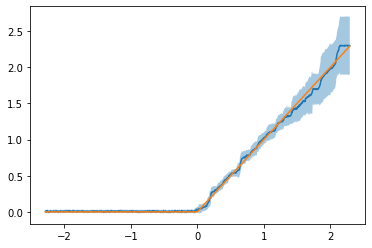

In [12]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

# IV Causal Forest

In [41]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 1000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [42]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=4000, min_samples_leaf=20,
                     min_impurity_decrease = 0.001, max_samples=.9, max_depth=None,
                     warm_start=False, inference=True,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [43]:
%time est.fit(X, T, y, Z=Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\econml\grf\_forest_classes.py:281: UserWarning: A column-vector Z was passed when a 1d array was expected. Please change the shape of Z to (n_samples,), for example using ravel().
  alpha = self.get_alpha(X, Taug, y, **kwargs)


Wall time: 10.4 s


CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=20,
               n_estimators=4000, n_jobs=-1, random_state=123)

In [44]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Wall time: 1.78 s


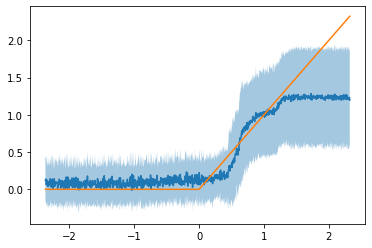

In [46]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

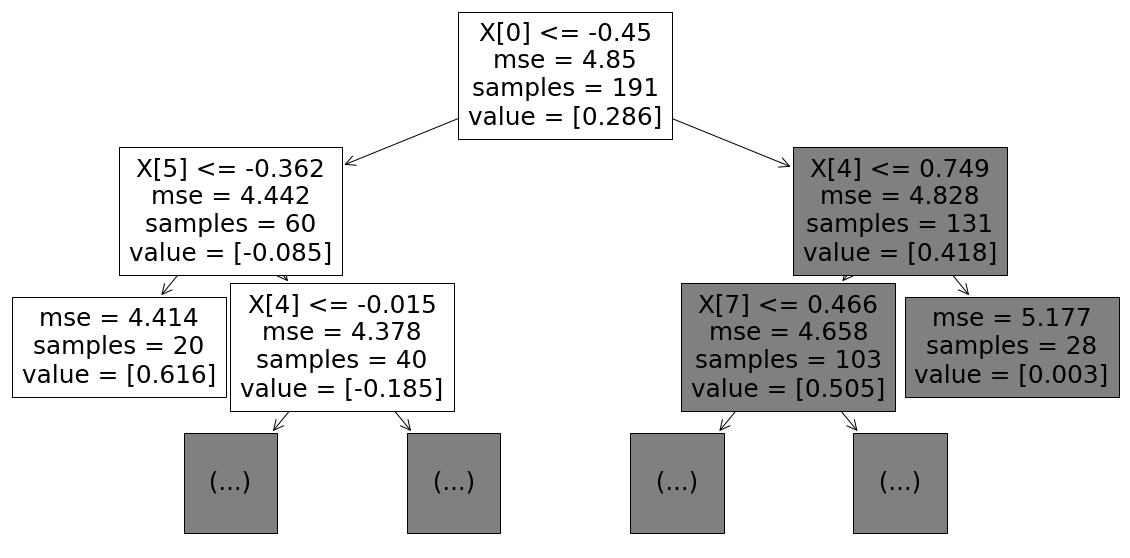

In [47]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

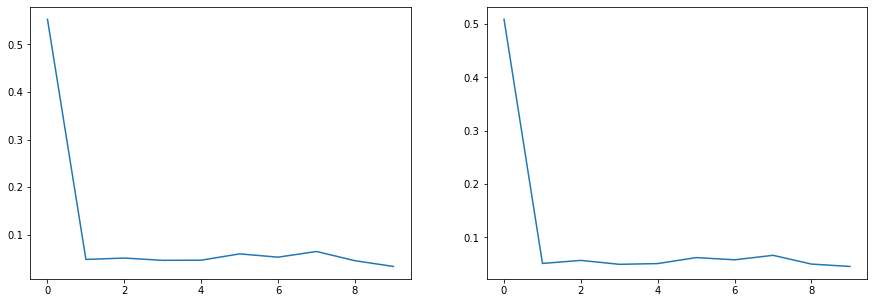

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [49]:
est[0].decision_path(X_test[:1])

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [50]:
est[0].apply(X_test[:1])

array([4], dtype=int64)